In [16]:
import emcee
import matplotlib.pyplot as plt
import numpy as np
import corner
import scipy.optimize as op

%matplotlib inline


In [17]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

<Container object of 3 artists>

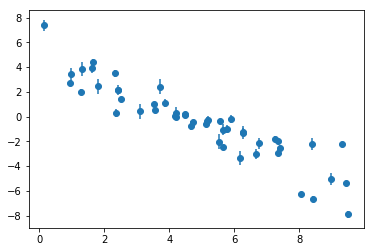

In [18]:
plt.figure()
plt.scatter(x,y)
plt.errorbar(x, y, xerr=0.0, yerr=yerr ,linestyle="None")


In [19]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [20]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [21]:
print result

      fun: 19.683449099498638
 hess_inv: array([[ 0.00611786, -0.02802516,  0.00553039],
       [-0.02802516,  0.13316722, -0.02418833],
       [ 0.00553039, -0.02418833,  0.02137977]])
      jac: array([  1.43051147e-06,   0.00000000e+00,  -7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([-1.03234409,  4.63769432, -0.78010752])


In [22]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [23]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [24]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500)

(array([[-1.00111078,  4.50761864, -0.90872009],
        [-1.03587242,  4.71965834, -0.83995003],
        [-1.16272682,  5.21995959, -1.0013596 ],
        [-0.92293934,  4.22598306, -0.70891546],
        [-1.02584466,  4.65294048, -0.64359402],
        [-1.11047688,  4.94165046, -0.75516051],
        [-0.99562219,  4.44540104, -0.78832923],
        [-1.10882513,  5.14592536, -0.77448776],
        [-1.15908024,  5.16363882, -0.81316633],
        [-1.1077872 ,  5.02054766, -0.93047369],
        [-0.95018777,  4.35691753, -0.64906153],
        [-1.02630317,  4.52001577, -0.71437746],
        [-0.94509642,  4.2693319 , -0.48851842],
        [-1.13491135,  5.11734879, -0.82546233],
        [-1.07293321,  4.70409699, -0.64727788],
        [-1.12289571,  4.94577695, -0.96593999],
        [-0.86332455,  3.82815545, -0.75833671],
        [-1.00799717,  4.56349018, -0.78538976],
        [-1.11239277,  5.05893844, -0.68242191],
        [-1.03894499,  4.69892388, -0.82462452],
        [-1.02068068

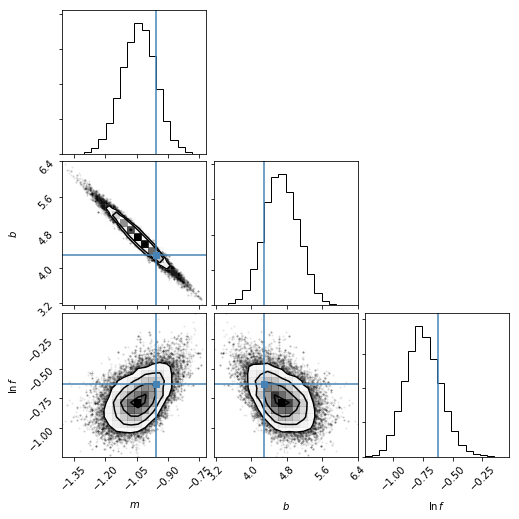

In [27]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")

<Container object of 3 artists>

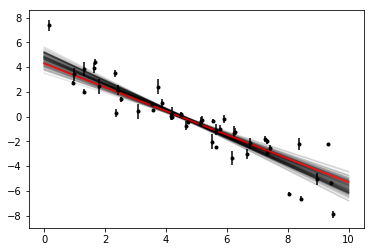

In [28]:
import matplotlib.pyplot as pl
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")


In [32]:
print np.median(np.exp(samples[:,2])),np.std(np.exp(samples[:,2]))

0.469162374478 0.0725917212459
